# Heat Conduction in a Thin Copper Rod
To begin this exploration of numerical solutions to partial differential equations, I start by comparing numerical and analytical solutions to the heat equation in a long, one-dimensional copper rod initially at 25 $^{\circ} C$ with one end held at 100 $^{\circ} C$. It is assumed that the thermal diffusivity of copper is constant at 111 $mm^{2}/s$<sub>[1]</sub>. That is:

$$ \dfrac{\partial T}{\partial t} = \alpha \dfrac{\partial^{2} T}{\partial x^{2}}, \quad T_{0} = 100 \, ^{\circ} C, \quad T_{a} = 25 \, ^{\circ} C, \quad \alpha = 111 \, \frac{mm^{2}}{s} $$

which has the analytical solution below<sub>[2]</sub>.

$$ T(x, \, t) = \left ( T_{0} - T_{a} \right ) \left [ 1 - \text{erf} \left ( \dfrac{x}{2 \sqrt{\alpha t}} \right ) \right ] + T_{a}$$

First, the exact solution to this problem is formulated:

In [1]:
import numpy as np
from scipy.special import erf

# Parameter definitions:
T0 = 100 # (C)
Ta = 25 # (C)
alpha = 111 # (mm^2/s)

# Analytical solution definition:
def T(x, t):
    return (T0 - Ta)*(1 - erf(x/(2*np.sqrt(alpha*t)))) + Ta

Replacing partial derivatives with finite-difference approximations creates an equation that can be applied iteratively to discrete nodes along the copper rod. Superscripts denote discrete times and subscripts denote node. $l$ and $i$ are the current time step and node, respectively.

$$ \dfrac{\partial T}{\partial t} \approx \dfrac{T^{l + 1}_{i} - T^{l}_{i}}{\Delta t}, \quad \dfrac{\partial^{2} T}{\partial x^{2}} \approx \dfrac{T^{l}_{i + 1} - 2T^{l}_{i} + T^{l}_{i - 1}}{(\Delta x)^{2}} $$

$$ \therefore \quad \dfrac{T^{l + 1}_{i} - T^{l}_{i}}{\Delta t} = \alpha \dfrac{T^{l}_{i + 1} - 2T^{l}_{i} + T^{l}_{i - 1}}{(\Delta x)^{2}} $$

A new term can be defined and the expression rearranged to solve for the temperature of a particular node at the next time step:

$$ \lambda \equiv \dfrac{\alpha (\Delta t)}{(\Delta x)^{2}} $$

$$ T^{l + 1}_{i} = T^{l}_{i} + \lambda \left ( T^{l}_{i + 1} - 2T^{l}_{i} + T^{l}_{i - 1} \right ) $$

It is known $\Delta t$ must satisfy the following for the numerical solution to converge<sub>[3]</sub>:

$$ \Delta t \leq \dfrac{(\Delta x)^{2}}{2 \alpha} $$

This numerical computation is now employed to get the PDE solution in the form of a position-time matrix.

In [2]:
# tqdm handles progress bars.
from tqdm import tqdm

# Time and space limits for the computation should be specified. However, the rod in this example is infinitely long.
t_stop = 10 # (s)
x_stop = 150 # (mm)

# spatial and temporal steps, ensuring the time step is sufficiently small to allow convergence:
Dx = 0.1
Dt = (Dx**2)/(2*alpha)
lam = (alpha*Dt)/(Dx**2)

# Initial condition and boundary condition:
num_nodes = int(x_stop/Dx)
num_time_steps = int(np.ceil(t_stop/Dt))
T_exp = Ta*np.ones((num_nodes, num_time_steps))
T_exp[0, :] = num_time_steps*[T0]

# Compute the rod temperature distribution at every time step:
for l in tqdm(range(num_time_steps - 1), desc='Preparing Explicit Numerical Solution:'):
    for i in range(1, num_nodes - 1):
        T_exp[i, l + 1] = T_exp[i, l] + lam*(T_exp[i + 1, l] - 2*T_exp[i, l] + T_exp[i - 1, l])

Preparing Explicit Numerical Solution:: 100%|█████████████████████████████████| 221999/221999 [12:16<00:00, 301.28it/s]


### Visualization
For the sake of efficiency in updating the animation of the temperature distribution evolving with time, function calls should be minimized. The previously-defined analytical solution to the PDE is now used to produce a matrix of data points.

In [3]:
T_exact = np.zeros((num_nodes, num_time_steps))
T_exact[:, 0] = [T0] + (num_nodes - 1)*[Ta]
xs = np.arange(0, x_stop, Dx)
for l in tqdm(range(1, num_time_steps - 1), desc='Preparing Analytical Solution'):
    t = Dt*l
    T_exact[:, l] = T(xs, t)

Preparing Analytical Solution: 100%|█████████████████████████████████████████| 221998/221998 [00:23<00:00, 9582.48it/s]


The animation below compares the analytical solution to the explicit numerically-computed solution.

<IPython.core.display.Javascript object>


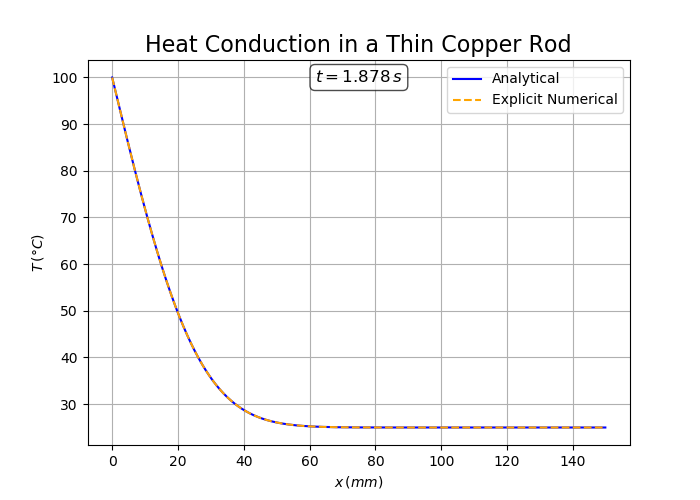

In [5]:
%matplotlib notebook

import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig, ax = plt.subplots(figsize=[7, 5])
    
# Initially plot the data:
t = 0.0
T_exact_t = T_exact[:, 0]
T_exp_t = T_exp[:, 0]
ax.set_title('Heat Conduction in a Thin Copper Rod', fontsize=16)
ax.set_xlabel(r'$x \, (mm)$')
ax.set_ylabel(r'$T \, (\degree C)$')
exact_plot, = ax.plot(xs, T_exact_t, color='blue', linestyle='-', label='Analytical')
exp_plot, = ax.plot(xs, T_exp_t, color='orange', linestyle='--', label='Explicit Numerical')
t_label = ax.text(75, 100, r'$t = %.3f$' %t, bbox={'boxstyle':'round', 'facecolor':'w', 'alpha':0.7}, fontsize=12, 
                  horizontalalignment='center', verticalalignment='center')
ax.legend()
ax.grid()

# Target framerate is ~15 fps. The factor "F" is chosen such that the number of frames "f" is compatible with a delay between
# frames "d" of 67 ms (~15 fps):
D = t_stop*1000 # (ms)
d = 67 # (ms)
f = int(D/d) # (frames)
F = int(num_time_steps/f)

# Function updating the plotted data. This is called each frame of the animation.
def update(l):
    
    # Get new data:
    l *= F
    t = l*Dt
    T_exact_t = T_exact[:, l]
    T_exp_t = T_exp[:, l]
    
    # Assign the new data to the plots:
    exact_plot.set_data(xs, T_exact_t)
    exp_plot.set_data(xs, T_exp_t)
    t_label.set_text(r'$t = %.3f \, s$' %t)
    
# Set up the animation.
ani = animation.FuncAnimation(fig, update, frames=f, interval=d, repeat=True)

# References
1. Thermal diffusivity. (2020, June 16). Retrieved July 08, 2020, from https://en.wikipedia.org/wiki/Thermal_diffusivity
2. Callister, W., &amp; Rethwisch, D. (2008). Diffusion. In Fundamentals of Materials Science and Engineering (3rd ed., pp. 167-168). Hoboken, NJ: Wiley.
3. Chapra, S. C., &amp; Canale, R. P. (2015). Part Eight. In Numerical Methods for Engineers (7th ed., pp. 844-914). New York, NY: McGraw-Hill Education.